The aim of this notebook is to show:

* how to train a simple MLP on MNIST data using the custom (cool!) code;
* that the results are comparable to PyTorch implementation.

# Imports and constants

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import mnist

from tqdm import tqdm

from models import Model
from layers import Linear, Sigmoid, Softmax, LayerTrainable
from losses import MultiCrossEntropy
from utils import preprocess_mnist_imgs, onehot, accuracy
from data import NumpyDataLoader

In [2]:
IMG_SIZE = 28  # Height and width of MNIST images
DATASET_SIZE = 10000  # Use 60000 for full ImageNet

HIDDEN_SIZE = 256
N_EPOCHS = 50
BATCH_SIZE = 128
LR = 0.1

N_RETRAIN = 5  # No. of trainings to compare custom impl with PyTorch 

# Load MNIST

In [3]:
x_train = mnist.train_images()
y_train = mnist.train_labels()

# Use only `DATASET_SIZE` samples
random_order = np.random.permutation(len(x_train))
x_train = x_train[random_order][:DATASET_SIZE]
y_train = y_train[random_order][:DATASET_SIZE]

x_train = preprocess_mnist_imgs(x_train, IMG_SIZE)
y_train = onehot(y_train)

In [4]:
x_val = preprocess_mnist_imgs(mnist.test_images(), IMG_SIZE)
y_val = mnist.test_labels()

In [5]:
train_loader = NumpyDataLoader(x_train, y_train, BATCH_SIZE, shuffle=True)
val_loader = NumpyDataLoader(x_val, y_val, BATCH_SIZE, shuffle=False)

# Train with custom

In [6]:
layers = [
    Linear(IMG_SIZE*IMG_SIZE, HIDDEN_SIZE),
    Sigmoid(),
    Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    Sigmoid(),
    Linear(HIDDEN_SIZE, 10),
    Softmax()
]
loss = MultiCrossEntropy()

In [ ]:
accs_custom = []
for i in range(N_RETRAIN):
    print(f'\n--- Training no. {i+1} ---')

    # Re-initialize
    for layer in layers:
        if isinstance(layer, LayerTrainable):
            layer.reset()
    model = Model(layers)
    
    accs = []
    for epoch in range(N_EPOCHS):
        tqdm_it = tqdm(train_loader, total=len(train_loader), leave=True)
        tqdm_it.set_description(f'Epoch: [{epoch+1}/{N_EPOCHS}]')

        # Train
        for x, y_true in tqdm_it:
            y_proba = model.forward(x)
            delta = loss.delta_fn(y_proba, y_true)
            model.backward(delta, LR)

        # Evaluate
        y_pred = []
        for x, _ in val_loader:
            y_proba = model.forward(x, store_grad=False)
            y_pred.append(np.argmax(y_proba, axis=1))
        y_pred = np.concatenate(y_pred)

        acc = accuracy(y_val, y_pred)
        accs.append(acc)
        print(f'Val. accuracy: {acc:.4f}')

    accs_custom.append(accs)

# Train with PyTorch

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
class TorchMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TorchMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = nn.functional.sigmoid(self.fc1(x))
        x = nn.functional.sigmoid(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [10]:
criterion = nn.CrossEntropyLoss()

In [ ]:
accs_torch = []
for i in range(N_RETRAIN):
    print(f'\n--- Training no. {i+1} ---')

    # Re-initialize
    model = TorchMLP(IMG_SIZE*IMG_SIZE, HIDDEN_SIZE, 10)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

    accs = []
    for epoch in range(N_EPOCHS):
        tqdm_it = tqdm(train_loader, total=len(train_loader), leave=True)
        tqdm_it.set_description(f'Epoch: [{epoch+1}/{N_EPOCHS}]')
        
        # Train
        model.train()
        for x, y_true in tqdm_it:
            x = torch.tensor(x)
            y_true = torch.tensor(y_true)

            y_pred = model(x)
            loss = criterion(y_pred, y_true)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # Evaluate
        model.eval()
        y_pred = []
        with torch.no_grad():
            for x, _ in val_loader:
                x = torch.tensor(x)
                y_proba = model(x)
                y_pred.append(torch.argmax(y_proba, axis=1).numpy())
        y_pred = np.concatenate(y_pred)

        acc = accuracy(y_val, y_pred)
        accs.append(acc)
        print(f'Val. accuracy: {acc:.4f}')

    accs_torch.append(accs)

# Compare

In [12]:
def series_mean(series: list):
    return np.array([
        np.mean(elements)
        for elements in zip(*series)
    ])

def series_std(series: list):
    return np.array([
        np.std(elements)
        for elements in zip(*series)
    ])

In [13]:
mean_custom = series_mean(accs_custom)
std_custom = series_std(accs_custom)

mean_torch = series_mean(accs_torch)
std_torch = series_std(accs_torch)

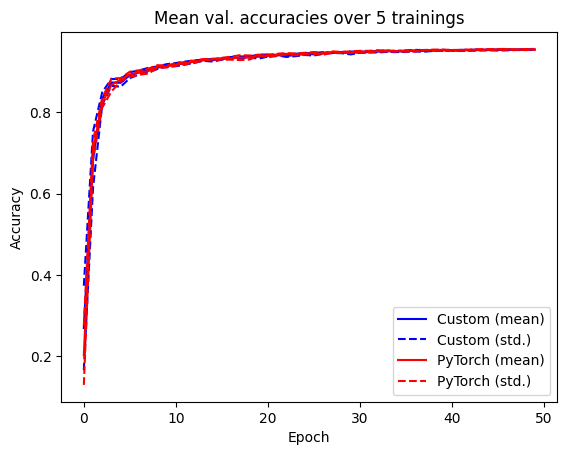

In [17]:
plt.plot(mean_custom, 'b', label='Custom (mean)')
plt.plot(mean_custom-std_custom, 'b--', label='Custom (std.)')
plt.plot(mean_custom+std_custom, 'b--')

plt.plot(mean_torch, 'r', label='PyTorch (mean)')
plt.plot(mean_torch-std_torch, 'r--', label='PyTorch (std.)')
plt.plot(mean_torch+std_torch, 'r--')

plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Mean val. accuracies over 5 trainings')
plt.show()